# Virus-Host Species Relation Extraction
## Notebook 3 - Generative Model Training
### UC Davis Epicenter for Disease Dynamics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

# Connect to the database backend and initalize a Snorkel session
#from lib.init import *
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

VirusHost = candidate_subclass('VirusHost', ['virus', 'host'])

# gold (human-labeled) development set labels
from util_virushost import load_external_labels

missed = load_external_labels(session, VirusHost, annotator_name = 'gold', split = 1)

L_gold_dev = load_gold_labels(session, annotator_name='gold', split = 1)
L_gold_dev

AnnotatorLabels created: 0


<150x1 sparse matrix of type '<class 'numpy.int32'>'
	with 118 stored elements in Compressed Sparse Row format>

In [2]:
missed = load_external_labels(session, VirusHost, annotator_name = 'gold', split = 2)

L_gold_test = load_gold_labels(session, annotator_name = 'gold', split = 2)
L_gold_test

AnnotatorLabels created: 0


<357x1 sparse matrix of type '<class 'numpy.int32'>'
	with 38 stored elements in Compressed Sparse Row format>

## Part III: Fitting a Generative Model
Generative models estimate joint probability of x and y in order to generate new data.
<br>
<br>
In our case, the Generative Model will unify weak sources (the individual LFs) by maximizing the marginal likelihood of the LFs to learn model parameters. We estimate the accuracy of each LF.
<br>
<br>
Intuitively, the labeling functions are modeled based on how much they agree or disagree with each other. Once the model is trained, the outputs of the LFs are combined into a single, noise-aware training label set (called 'train_marginals') for our end extractor (the discriminative model, an LSTM network). 

In [3]:
# First, load label matrices from notebook 2
from snorkel.annotations import LabelAnnotator

labeler = LabelAnnotator(lfs = [])
L_train = labeler.load_matrix(session, split=0)
L_dev = labeler.load_matrix(session, split=1)
L_test = labeler.load_matrix(session, split=2)

### Generative Model
According to data programming, the generative model is used as a more sophisticated way to unify lower quality labeling functions. Since our labeling functions will not be perfect classifiers (some may be low-quality) their accuracies are modeled. 
<br>
<br>
**End goal**: produce a single set of denoised **training labels**, which are then used to train an end extraction model in Notebook 4. 
<br>
<br>
**Parameter Definitions**
<br>
epochs:     A single pass through all the data in your training set
<br>
step_size:  The factor by which we update model weights after computing the gradient
<br>
decay:      The rate our update factor dimishes (decay) over time.
<br>
<br>
While training the model, we should include dependencies between LFs that may affect output. The DependencySelector function identifies a set of likely dependencies for us.

In [4]:
# Detect dependencies between LFs
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold = 0.1)
len(deps)

69

#### Testing different hyperparameters to find the best accuracy
We use a grid search to tune hyperparameters, optimizing the model
<br>
<br>
#### Definitions:
- **Precision**: How often is the model correct when it predicts positive? 
<br>
<br>
$$Precision = \frac{truepositives}{truepositives + falsepositives}$$
<br>
<br>
- **Recall**: Helps when the cost of false negatives is high. A lower recall means there are more false negatives.
<br>
<br>
$$Recall = \frac{truepositives}{truepositives + falsenegatives}$$
<br>
<br>
- **F-1**: Overall measure of a model's accuracy, combining precision and recall. A good F-1 score means low false positives and low false negatives. The higher the score, the better (a perfect model having F-1 score of 1)

In [5]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch

param_ranges = {
    'step_size' : [1e-3, 1e-4, 1e-5, 1e-6, 0.1/L_train.shape[0]],
    'decay'     : [0.9, 0.95],
    'epochs'    : [50, 100],
    'reg_param' : [1e-3],
    'deps': [deps]
}

model_class_params = {
    'class_prior': True,
    'lf_prior': True,
    'lf_propensity' : True,
    'lf_class_propensity': True,
                     }

searcher = RandomSearch(GenerativeModel, param_ranges, L_train, n=5, model_class_params=model_class_params)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev)
run_stats

[1] Testing step_size = 1.00e-05, decay = 9.00e-01, epochs = 50, reg_param = 1.00e-03, deps = {(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0), (4, 9, 0), (6, 7, 0), (2, 8, 0), (11, 13, 0), (8, 9, 0), (6, 10, 0), (10, 15, 0), (3, 4, 0), (4, 14, 0), (1, 3, 0), (2, 3, 0), (0, 5, 0), (14, 15, 0), (2, 14, 0), (1, 14, 0), (12, 15, 0), (0, 2, 0), (2, 4, 0), (9, 11, 0), (1, 4, 0), (10, 11, 0), (6, 14, 0), (1, 9, 0), (5, 14, 0), (0, 15, 0), (2, 9, 0), (4, 10, 0), (8, 10, 0), (10, 12, 0), (6, 11, 0), (3, 7, 0), (2, 10, 0), (4, 15, 0), (0, 6, 0), (9, 15, 0), (7, 14, 0), (0, 9, 0), (2, 15, 0), (4, 12, 0), (5, 10, 0), (0, 3, 0), (9, 10, 0), (8, 14, 0), (6, 15, 0), (1, 8, 0), (12, 13, 0), (2, 6, 0), (1, 6, 0), (4, 6, 0), (6, 8, 0), (7, 10, 0), (10, 14, 0), (0, 7, 0), (9, 14, 0), (7, 9, 0), (0, 10, 0), (13, 15, 0), (1, 12, 0), (5, 9, 0), (0, 4, 0), (5, 6, 0), (6, 12, 0), (1, 15, 0), (12, 14, 0), (11, 14, 0)}
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.47904191616766467
[GenerativeModel] Mode

,step_size,decay,epochs,reg_param,deps,Prec.,Rec.,F-1
1,0.000026,0.95,100,0.001,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0),...",0.760870,0.625000,0.686275
2,0.000010,0.95,50,0.001,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0),...",0.760870,0.625000,0.686275
0,0.000010,0.90,50,0.001,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0),...",0.727273,0.357143,0.479042
4,0.000001,0.95,100,0.001,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0),...",0.727273,0.357143,0.479042
3,0.000100,0.90,100,0.001,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0),...",0.000000,0.000000,0.000000


The searcher selected the optimal model with the optimal hyperparameters and included dependencies.

In [6]:
# Run just one specified generative model 
# comment out this block to let the above searcher find best model

#gen_model = GenerativeModel()
    # Optioanl params to include in GenerativeModel :
    # class_prior=True, lf_prior=True, lf_propensity=True, lf_class_propensity=True
#gen_model.train(L_train, epochs=100, decay=0.95, step_size=2.6e-5, reg_param=1e-3)

In [7]:
# The marginal predictions of the training labels
train_marginals = gen_model.marginals(L_train)

In [8]:
len(train_marginals)

3795

Let's visually explore the distribution of predicted training marginals. 
<br>
**Ideally, there should get a bimodal distribution with large separation between each peaks**

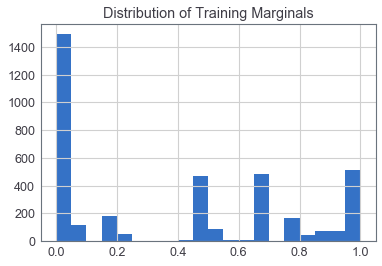

In [9]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20, range=(0.0, 1.0))
plt.title('Distribution of Training Marginals')
plt.show()

The X axis is probability of classifying as positive or negative label (So a 0.5 would not be classified as anything). Based on shape above, ideally there are more values on the ends which indicate good coverage on both the positive and negative side.

In [10]:
import pandas as pd

LF_stats = pd.DataFrame(L_train.lf_stats(session))

LF_stats.sort_values(by = 'Coverage')


,j,Coverage,Overlaps,Conflicts
LF_distant_supervision,14,0.000527,0.000527,0.000000
LF_uncertain,10,0.003426,0.003162,0.003162
LF_v_cause_h,6,0.005797,0.005797,0.001054
LF_positive2,4,0.044532,0.044532,0.008432
LF_infect,1,0.054809,0.054809,0.015020
LF_other_verbs,9,0.060606,0.058235,0.017128
LF_detect,0,0.062978,0.062978,0.015547
LF_neg_assertions,15,0.069565,0.069565,0.010804
LF_isolate,2,0.075362,0.075362,0.021607
LF_far_h_v,12,0.091436,0.072200,0.032148


### Checking performance against development set labels

We will run the labeler on the development set, load in hand labels, then evaluate LF performance.

#### Model Accuracies

In [11]:
L_dev.lf_stats(session, L_gold_dev)

C:\Users\erica\Anaconda3\envs\snorkel\lib\site-packages\snorkel\annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_detect,0,0.093333,0.093333,0.000000,8,0,0,0,1.000000
LF_infect,1,0.066667,0.066667,0.006667,10,0,0,0,1.000000
LF_isolate,2,0.006667,0.006667,0.000000,0,0,0,0,NaN
LF_positive,3,0.166667,0.166667,0.006667,18,0,0,0,1.000000
LF_positive2,4,0.060000,0.060000,0.000000,5,0,0,0,1.000000
LF_misc,5,0.273333,0.273333,0.100000,29,1,0,0,0.966667
LF_v_cause_h,6,0.013333,0.013333,0.000000,2,0,0,0,1.000000
LF_v_h,7,0.413333,0.166667,0.000000,45,3,0,0,0.937500
LF_h_v,8,0.320000,0.200000,0.000000,43,0,0,0,1.000000
LF_other_verbs,9,0.140000,0.140000,0.013333,12,1,0,0,0.923077


In [12]:
# Generative Model Metrics

dev_marginals = gen_model.marginals(L_dev)

tp, fp, tn, fn = gen_model.error_analysis(
    session, 
    X_test = L_dev, 
    Y_test = L_gold_dev,
    b = 0.5,
    set_unlabeled_as_neg = False,
)

Scores (Un-adjusted)
Pos. class accuracy: 0.625
Neg. class accuracy: 0.5
Precision            0.959
Recall               0.625
F1                   0.757
----------------------------------------
TP: 70 | FP: 3 | TN: 3 | FN: 42



In [13]:
test_marginals = gen_model.marginals(L_test)

tp, fp, tn, fn = gen_model.error_analysis(
    session, 
    X_test = L_test, 
    Y_test = L_gold_test,
    b = 0.5,
    set_unlabeled_as_neg = False,
)

Scores (Un-adjusted)
Pos. class accuracy: 0.865
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.865
F1                   0.928
----------------------------------------
TP: 32 | FP: 0 | TN: 1 | FN: 5



In [14]:
# The sets tp, fp, tn, fn that come from the model error analysis can be viewed in the Viewer just like in intro. tutorial 2.

In [15]:
# view false positives
from snorkel.viewer import SentenceNgramViewer

SentenceNgramViewer(fn, session, height = 350)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[1], [2, 3], [0]], [[4]]], html='<head>\n<style>\nspan.candidate {\n    background-…

In [16]:
# Save training labels to use in end extraction model
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 3795 marginals
Wall time: 2.2 s


In [17]:
# convert to .py file
!jupyter nbconvert --to script snorkel_part_3.ipynb

[NbConvertApp] Converting notebook snorkel_part_3.ipynb to script
[NbConvertApp] Writing 7390 bytes to snorkel_part_3.py
